# The logit node

In [4]:
using RxInfer, Plots, Random
using StatsFuns: logistic, softplus
using Distributions: pdf
using HASoundProcessing.SEM.Extensions: Sigmoid

In [5]:
# Data
Random.seed!(123)

n_samples = 40

x_data = []
y_data = []
x_prev = -2.0

for t=1:n_samples
    push!(x_data, x_prev+0.1 + sqrt(0.01)*randn()) # State transition
    push!(y_data, logistic(x_data[end]) > rand()); # Observation
    x_prev = x_data[end]
end


In [6]:

@model function parametric_sigmoid_model(switch, η, θ, μ, σ)
    ξ ~ Normal(mean=μ+0.1, variance=σ)
    ζ ~ Uninformative()
    switch ~ Sigmoid(η * (ξ - θ), ζ)
end

initialization = @initialization begin
    q(ξ) = NormalMeanVariance(0.0, 100.0)  
    q(ζ) = PointMass(1.0)
end

autoupdatesq = @autoupdates begin
    μ, σ = mean_var(q(ξ))
end
constraints = @constraints begin
    q(ζ, ξ) = MeanField()
end


rxengine = infer(
    model = parametric_sigmoid_model(η = 1.0, θ = 0.0),
    data = (switch = y_data,),
    initialization = initialization,
    keephistory = length(x_data),
    constraints = MeanField(),
    autoupdates = autoupdatesq,
    historyvars = (ξ = KeepLast(),ζ = KeepLast()),
    autostart = true,
    free_energy = true,
    iterations = 20,
)

U = 0.4703521156982684
U = 0.4576572604142203
U = 0.4571581644144619
U = 0.4587827596849564
U = 0.4605832281776342
U = 0.4621319110028913
U = 0.4633700579820952
U = 0.4643323427424532
U = 0.4650710814910056
U = 0.46563501411250385
U = 0.46606437801344613
U = 0.4663908970954478
U = 0.46663908290720124
U = 0.46682769731182566
U = 0.46697103782253174
U = 0.4670799778151799
U = 0.46716277952250207
U = 0.46722571929924617
U = 0.46727356486418314
U = 0.46730993828385725
U = 0.24416244173014112
U = 0.24415019460557297
U = 0.24414499338382986
U = 0.24414275846005767
U = 0.24414179308196052
U = 0.24414137512287695
U = 0.24414119398588502
U = 0.24414111544955702
U = 0.2441410813917591
U = 0.24414106662115212
U = 0.2441410602150234
U = 0.24414105743659179
U = 0.24414105623153728
U = 0.2441410557088825
U = 0.244141055482197
U = 0.24414105538387912
U = 0.24414105534123673
U = 0.24414105532274172
U = 0.24414105531472025
U = 0.24414105531124095
U = 0.16613647738843743
U = 0.1661417195811305
U = 0.166

RxInferenceEngine:
  Posteriors stream    | enabled for (anonymous_var_graphppl, ξ, ζ)
  Free Energy stream   | enabled
  Posteriors history   | available for (ξ, ζ)
  Free Energy history  | available
  Enabled events       | [  ]

In [7]:
# Extract posterior statistics
m_x = [mean(dist) for dist in rxengine.history[:ξ]]
v_x = [var(dist) for dist in rxengine.history[:ξ]];


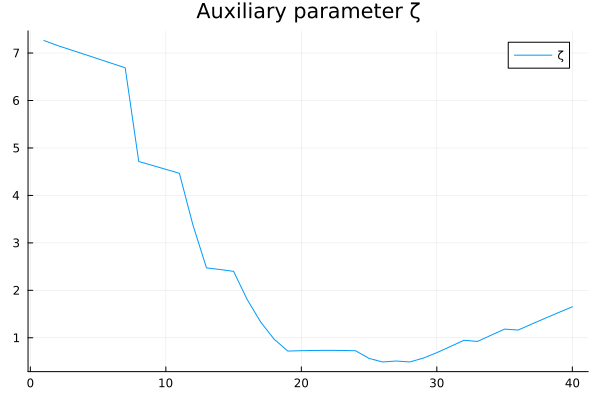

In [8]:
plot(mean.(rxengine.history[:ζ]),label="ζ", title="Auxiliary parameter ζ")

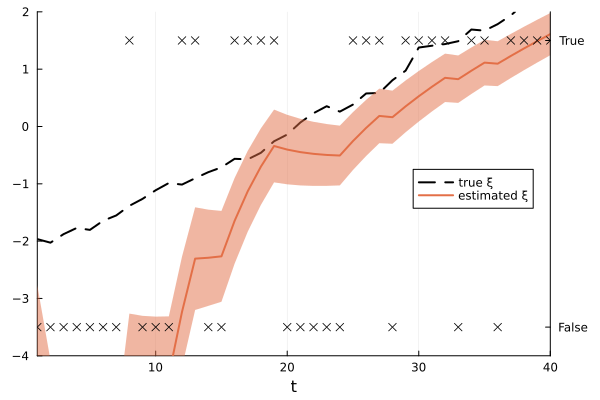

In [9]:
n_plot = length(x_data)

p = plot(1:n_plot, x_data[1:n_plot], 
     linestyle=:dash, 
     color=:black, 
     linewidth=2, 
     label="true ξ",
     xlabel="t",
     ylim=(-4, 2), 
     xlim=(1, n_plot),
     legend=:right)

plot!(p, 1:n_plot, m_x[1:n_plot], 
      ribbon=sqrt.(v_x[1:n_plot]), 
      linewidth=2, 
      label="estimated ξ")

p2 = Plots.twinx(p)

scatter!(p2, 1:n_plot, y_data[1:n_plot],
         label=false,
         yticks=([0.0, 1.0], ["False", "True"]),
         color=:black,
         xlim=(1, n_plot),
         marker=:x,
         ylim=(-0.1, 1.1))


display(p)


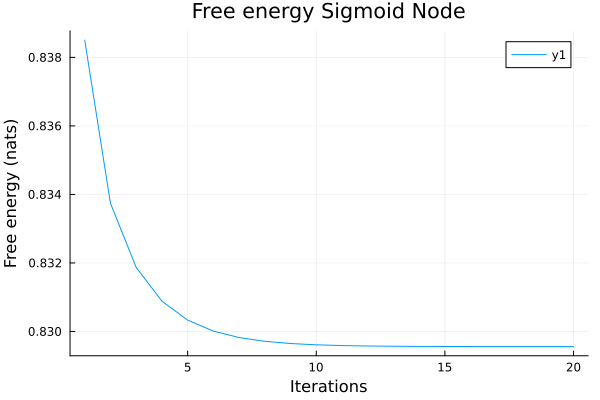

In [15]:
plot(rxengine.free_energy_history,title="Free energy Sigmoid Node", xlabel="Iterations", ylabel="Free energy (nats)")